In [1]:
import sys
sys.path.insert(0, '../')

# predict_model pipeline

This notebook explains how to make predictions with the trained model. The predictions will be plotted against the targets, and root mean squared error (RMSE) will be reported both for the predictions and the baseline, which is the mean of the targets, along with the correlation between predictions and targets.

It is important that the correct fold is selected as the statistics used during training are also necessary to be used during prediction.

## Step 1 - Creating the dataset and dataloader

**File:** ```src/data/features_dataloader.py```

We start off with creating a torch dataset over the test Features.

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from argparse import ArgumentParser
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path

from torch.utils.data import DataLoader
from src.data.feature_dataloader import Features
from src.models.hydramr import HydraMRRegressor, HydraMRRegressor_old

The following variables are parameters that can be changed via arguments when calling the ```predict_model.py``` script.

In [4]:
model = '../models/HydraMRRegressor.pt'
data = '../data/processed/features.hdf5'
feature_extractors = ['MultiRocketMV_50000', 'HydraMV_8_64']
name_identifier = ''
data_type = 'test'
batch_size = 32
plot_during = False
hidden_dim = 64
fold = 1
model_depth = 0
batch_norm = True

We create a dataset over the features and plot a histogram of the four targets.

Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             test 
                     Data length:           1446 
                     Features selected:                      
                         - Names:           ['MultiRocketMV_50000', 'HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     


100%|██████████| 1446/1446 [00:00<00:00, 3856.13it/s]


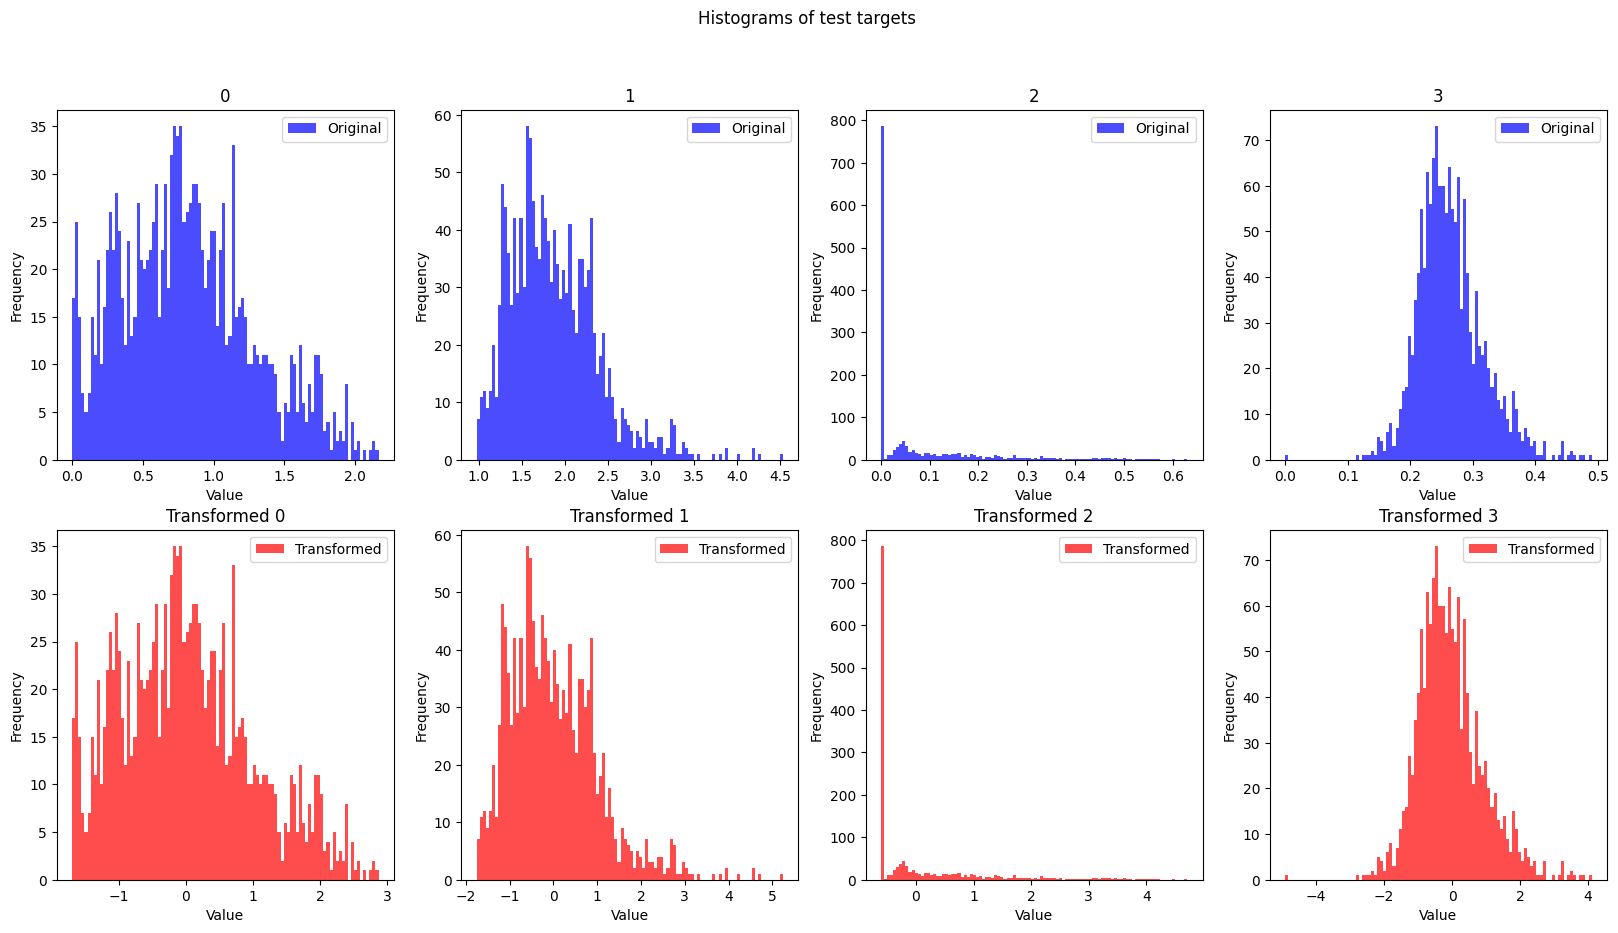

In [5]:
testset = Features(data_path = data,
                   data_type = data_type,
                   feature_extractors = feature_extractors,
                   fold = fold,
                   name_identifier = name_identifier)

testset.plot_data()

## Step 2 - Predicting using the trained model

We are now ready to use the model we trained (as demonstrated in ```train_model.ipynb```), 